#IOTA6-6 - Testing Larger Amplitude Particles with the Nonlinear Element - PT 6 -Further Structured Tune variations

The previous notebook (part 5) laid the groundwork for systematic analysis of the tune through the NL drift section and its impact on the preservation of the invariant.

However, that notebook only considered single particle behavior, and tested tunes only between 0.1 and 0.9 through the drift. David has suggested that I consider a broad range of tunes (increasing by a factor of 2) up to ~ 0.6 or so. I will probably only consider tunes up to 0.4, as approaching the half-integer tune through the drift causes the invariants to fluctuate wildly.

In [1]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [2]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 20/08/2015 

CPython 2.7.10
IPython 3.1.0


In [2]:
import sys, os
import synergia
from mpi4py import MPI
import synergia_workflow

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from elliptic import EllipticBeam6D
from base_diagnostics import lfplot

###Helper Functions

In [3]:
import re
def Find(pat, text):
    match = re.search(pat, text)
    if match:
        return match.group()
    #    print match.group()
    else:
        return
    #    print 'not found'

def get_lattice_files(relpath):
    lfiles = []
    files = os.listdir(relpath)
    
    for filename in files:
        if filename.find('nll_40slices') > -1 and filename.endswith('.madx'):
            lfiles.append(filename)
    return lfiles
    

def get_base_nll(nn, l0, mu0, t, c):
    '''Construct the nonlinear element. Taken from madx script by A. Valishev. 
    Verified by David's python script for pyOrbit.
    
    '''
    #musect=mu0+0.5;
    f0=l0/4.0*(1.0+1.0/np.tan(np.pi*mu0)**2); #focal length
    betae=l0/np.sqrt(1.0-(1.0-l0/2.0/f0)**2); #entrance beta function
    alphae=l0/2.0/f0/np.sqrt(1.0-(1.0-l0/2.0/f0)**2); #entrance alpha function
    betas=l0*(1-l0/4.0/f0)/np.sqrt(1.0-(1.0-l0/2.0/f0)**2); #middle beta function
    #value,f0,betae,alfae,betas;
    
    return [f0, betae,alphae,betas]

class Pickle_helper:
    __getstate_manages_dict__ = 1
    def __init__(self, *args):
        self.args = args
    def __getinitargs__(self):
        return self.args
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, state):
        self.__dict__ = state

class turn_actions(synergia.simulation.Propagate_actions, Pickle_helper):
    def __init__(self, mat):
        synergia.simulation.Propagate_actions.__init__(self)
        Pickle_helper.__init__(self, mat)
        self.matrix = mat #R-matrix being imported
    def turn_end_action(self, stepper, bunch, turn_num):
        '''Move particles through a single drift and advance the reference particle by the drift length'''
        
        #define matrix
        R_matrix = self.matrix
        
        particles = bunch.get_local_particles();
        for particle in particles:
            new_particle = np.dot(R_matrix,particle[0:6]) #This is for full 6x6 multiplication, not using currently.
            
            #just perform x+y-plane updates
            #new_particle = np.zeros(6)
            #new_particle[0:2] = np.dot(R_matrix[0:2,0:2],particle[0:2])
            #new_particle[2:4] = np.dot(R_matrix[2:4,2:4],particle[2:4])
            particle[0:6] = new_particle

###Main Simulation Script

In [4]:
from base_diagnostics import workflow
from base_diagnostics import latticework
from base_diagnostics import elliptic_sp
from elliptic import EllipticBeam6D
#Construct R-matrices

lattice_folder = '/Users/ncook/Synergia_Tests/lattices/6-6_nll_toy_ensemble/'
latticefiles = get_lattice_files(lattice_folder)
simulations = {} #construct a dictionary

for latticefile in latticefiles:
    lattice = synergia.lattice.MadX_reader().get_lattice("base", os.path.join(lattice_folder,latticefile))
    
    #annoying stuff to extract name and tune
    name = Find(r'\dpt\d+_',latticefile)[:-1]
    decimals = Find(r'pt\d+',name)[2::]
    l = len(decimals)
    tune = int(decimals)/(10.**l)
    
    for elem in lattice.get_elements():
        if elem.get_type() == 'nllens':
            elem.set_string_attribute("extractor_type", "chef_propagate")

    nsteps_per_element = 10
    nsteps = len(lattice.get_elements())*nsteps_per_element
    order = 1
    
    name += '_tune'
    outputdir = name
    opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
    opts.macro_particles = 1000
    opts.emits = [1.0e-5,1.0e-6, 1.0e-7] #only constructing bunches of 2 different sizes here
    opts.lattice = lattice
    workflow.make_path(outputdir)
    opts.relpath = opts.output_dir

    stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
    lattice_simulator = stepper.get_lattice_simulator()
    
    
    #construct the R-matrix
    opts.new_tune = tune
    opts.lnll = lattice.get_length()
    opts.nseg = 40
    opts.t = 0.4
    opts.c = 0.01
    vals = get_base_nll(opts.nseg, opts.lnll, opts.new_tune, opts.t, opts.c)
    
    opts.f0 = vals[0]
    opts.betae = vals[1]
    opts.alphae = vals[2]
    opts.beta0 = vals[3]

    toy_R = latticework.make_R(opts.f0)
    
    #construct the operator using our toy R matrix
    turn_action = turn_actions(toy_R)
    
    #construct a bunch and populate with 3 particles of varying emittance
    particles = EllipticBeam6D.toyEllipticalBeam6D(opts)
                     
    for index in range(len(opts.emits)):
        bunch = particles[index]
        initialH,initialI = elliptic_sp.calc_bunch_H(bunch,opts)
        bunch_mean = np.mean(initialH)
        bunch_std = np.std(initialH)
        bunch_var = (bunch_std/bunch_mean)*100
        print "Constructed bunch with {} macroparticles, having mean H: {} and std: {}%".format(opts.macro_particles, bunch_mean,bunch_var)
    
    print
    opts.num_total_particles = opts.macro_particles*len(opts.emits)
    opts.tracked_particles = opts.num_total_particles
    
    #load the particles into a synergia bunch
    particles_file = 'myBunch' + str(name) + '.txt'
    comm = synergia.utils.Commxx(True)
    bucket_length = 0.05 #potential workaround
    ref = lattice.get_reference_particle()
    myBunch = synergia.bunch.Bunch(ref,opts.num_total_particles, opts.real_particles, comm,bucket_length)
    local_particles = myBunch.get_local_particles()
    local_particles[:,:] = particles.reshape((opts.num_total_particles,7))[::]
    
    #construct a bunch simulator and add diagnostics
    bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

    #basic diagnostics - PER STEP
    basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
    bunch_simulator.add_per_step(basicdiag)

    #include full diagnostics
    fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
    bunch_simulator.add_per_turn(fulldiag)

    #tracking diagnostics - PER STEP
    diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
    #Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
    bunch_simulator.add_per_step(diagnostics)

    #particle diagnostics - PER TURN
    particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
    bunch_simulator.add_per_turn(particlediag)
    
    
    #populate the dictionary storing relevant simulation parameters, objects, and pointers to data
    simulations[name] = {}
    
    current = simulations[name]
    current['lattice'] = lattice
    current['tune'] = tune
    current['outputdir'] = outputdir
    current['lattice_simulator'] = lattice_simulator
    current['stepper'] = stepper
    current['opts'] = opts
    current['R_matrix'] = toy_R
    current['vals'] = vals
    current['turn_action'] = turn_action
    current['bunch'] = myBunch
    current['bunch_simulator'] = bunch_simulator
    
    
    print "Performing simulation for lattice " + str(name) + "."
    
    #now perform the simulation
    opts.turns = 100
    propagator = synergia.simulation.Propagator(stepper)
    propagator.set_checkpoint_period(opts.checkpointperiod)
    propagator.propagate(bunch_simulator, turn_action,
                     opts.turns, opts.maxturns,opts.verbosity)

    #clean up files
    workflow.cleanup(opts.output_dir)

Constructed bunch with 1000 macroparticles, having mean H: 1.01945949088e-05 and std: 12.3317424845%
Constructed bunch with 1000 macroparticles, having mean H: 1.02410116866e-06 and std: 14.2504783561%
Constructed bunch with 1000 macroparticles, having mean H: 1.02914010762e-07 and std: 14.570213798%

Performing simulation for lattice 0pt025_tune.
Constructed bunch with 1000 macroparticles, having mean H: 1.08559823975e-05 and std: 23.9990322523%
Constructed bunch with 1000 macroparticles, having mean H: 1.10924778475e-06 and std: 27.6642005102%
Constructed bunch with 1000 macroparticles, having mean H: 1.12738768472e-07 and std: 28.2559701002%

Performing simulation for lattice 0pt05_tune.
Constructed bunch with 1000 macroparticles, having mean H: 1.36941582829e-05 and std: 43.1767363613%
Constructed bunch with 1000 macroparticles, having mean H: 1.48223023858e-06 and std: 49.323493099%
Constructed bunch with 1000 macroparticles, having mean H: 1.5557092757e-07 and std: 50.3688079414%

###Analysis

I should now have output files for tunes 0.025, 0.05, 0.1, 0.2, 0.3, and 0.4. Each `particles` file contains bunch information for two individual bunches - one with emittance 1.e-5 and one with emittance 1.e-7. Thus I need to adjust my scripts to deal with the multiple bunch processing.

In [6]:
hVals, iVals = elliptic_sp.calc_bunch_H(myBunch, opts)

In [11]:
hArray, iArray = elliptic_sp.toy_calc_elliptic_Invariant(opts)

In [8]:
for emit in opts.emits:
    print str(emit) 

1e-05
1e-06
1e-07


In [23]:
#bunchMeans is a dictionary. Each key corresponds to an emittance
#For each emittance, there is a list of arrays, with each array specifiying tune, Hmean, Hvar, Imean, Ivar for the bunch

bunchMeans = {}

for key in simulations.keys():
    current_opts = simulations[key]['opts']
    
    HS, IS = elliptic_sp.toy_analyze_invariant_bunch(current_opts)
    
    for emit in current_opts.emits:
        particle_Havgs = HS[str(emit)]
        H_mean = np.mean(particle_Havgs[:,1])
        Hvar_mean = np.mean(particle_Havgs[:,3])
        #print current_opts.name, str(H_mean)

        particle_Iavgs = IS[str(emit)]
        I_mean = np.mean(particle_Iavgs[:,1])
        Ivar_mean = np.mean(particle_Iavgs[:,3])

        if bunchMeans.has_key(str(emit)):
            stats = bunchMeans[str(emit)]
            bunchMeans[str(emit)] = np.vstack((stats,[current_opts.new_tune,H_mean,Hvar_mean,I_mean,Ivar_mean]))
            #stats.append([current_opts.new_tune,H_mean,Hvar_mean,I_mean,Ivar_mean])
        else:
            bunchMeans[str(emit)] = np.asarray([current_opts.new_tune,H_mean,Hvar_mean,I_mean,Ivar_mean])


In [9]:
#bunchMeans is a dictionary. Each key corresponds to an emittance
#For each emittance, there is a list of arrays, with each array specifiying tune, Hmean, Hvar, Imean, Ivar for the bunch

bunchMeans = {}

for key in simulations.keys():
    current_opts = simulations[key]['opts']
    
    HS, IS = elliptic_sp.toy_analyze_invariant_bunch(current_opts)
    
    for emit in current_opts.emits:
        particle_Havgs = HS[str(emit)]
        H_mean = np.mean(particle_Havgs[:,1])
        Hvar_mean = np.mean(particle_Havgs[:,3])
        Hvar_std = np.std(particle_Havgs[:,3])
        #print current_opts.name, str(H_mean)

        particle_Iavgs = IS[str(emit)]
        I_mean = np.mean(particle_Iavgs[:,1])
        Ivar_mean = np.mean(particle_Iavgs[:,3])
        Ivar_std = np.std(particle_Iavgs[:,3])
        
        if bunchMeans.has_key(str(emit)):
            stats = bunchMeans[str(emit)]
            bunchMeans[str(emit)] = np.vstack((stats,[current_opts.new_tune,H_mean,Hvar_mean,Hvar_std,I_mean,Ivar_mean,Ivar_std]))
            #stats.append([current_opts.new_tune,H_mean,Hvar_mean,I_mean,Ivar_mean])
        else:
            bunchMeans[str(emit)] = np.asarray([current_opts.new_tune,H_mean,Hvar_mean,Hvar_std,I_mean,Ivar_mean,Ivar_std])


In [10]:
print bunchMeans

{'1e-06': array([[  4.00000000e-01,   1.04573081e-06,   5.04224672e+00,
          3.74816967e+00,   2.55623035e-11,   4.59891383e+00,
          2.41721302e+00],
       [  3.00000000e-01,   1.01417187e-06,   1.68108527e+00,
          1.32732977e+00,   5.47495902e-11,   1.43054173e+00,
          7.73126625e-01],
       [  1.00000000e-01,   1.00033895e-06,   4.25240626e-02,
          3.42131166e-02,   1.01260702e-10,   3.49224591e-02,
          1.86822295e-02],
       [  5.00000000e-02,   9.99523701e-07,   5.83942035e-02,
          4.78499856e-02,   1.06457715e-10,   4.74818651e-02,
          2.60672992e-02],
       [  2.50000000e-02,   9.99327472e-07,   8.21573968e-02,
          6.72083597e-02,   1.07781319e-10,   6.71271968e-02,
          3.69739048e-02],
       [  2.00000000e-01,   1.00423647e-06,   5.16501184e-01,
          4.16259397e-01,   8.19751554e-11,   4.26929903e-01,
          2.31770096e-01]]), '1e-07': array([[  4.00000000e-01,   1.00737104e-07,   7.83674444e-01,
          7

In [118]:
import matplotlib
from matplotlib import gridspec

matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.scatterpoints'] = 1

def plotHvTune(means, log=False, fit=False):
    fig = plt.figure(figsize=(16,12))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios = [1,1]) 

    xlabel = 'Tune through NL drift'

    ax0 = plt.subplot(gs[0])
    ax0.set_title('Standard Deviation in H versus tune through NL drift',fontsize=14)
    ax0.set_xlabel(xlabel,fontsize=12)
    ax0.set_ylabel('$\sigma H / H_0$ [%]',fontsize=12)
    #ax0.set_aspect(aspect=2.0)

    ax1 = plt.subplot(gs[1])
    ax1.set_title('Standard Deviation in I versus tune through NL drift',fontsize=14)
    ax1.set_xlabel(xlabel,fontsize=12)
    ax1.set_ylabel('$\sigma I / I_0$ [%]',fontsize=12)
    #ax0.set_aspect(aspect=2.0)
    
    sv_title = 'sigmaH_vtune'
    colors = ['b','r','g','k','c','m']
    
    for index,key in enumerate(means.keys()):
        emit = key
        vals = means[key]
        #hstds are vals[]
        tunes = vals[:,0]
        hstds = vals[:,2]
        hstds_err = vals[:,3]
        istds = vals[:,5]
        istds_err = vals[:,6]
        yerror = (hstds_err/hstds)*y
        
        if log:
            
            ax0.scatter(np.log(tunes),np.log(hstds), c=colors[index], label=emit)
            #ax0.errorbar(tunes,np.log10(hstds), yerr=hstds_err, fmt='o', c=colors[index], label=emit)
            istds = vals[:,5]
            istds_err = vals[:,6]
            ax1.scatter(tunes,np.log(istds), c=colors[index], label=emit)
            
            if fit:
                slope = 3
                #offset = np.log10(float(emit)/1.e-7)
                if float(emit) == 1.e-7:
                    offset = 2.4
                elif float(emit) == 1.e-6:
                    offset = 4.05
                elif float(emit) == 1.e-5:
                    offset = 5.05
                print emit, offset
                #offset = np.log10(float(emit)/1.e-7) + 2
                #offset = 2 + np.abs(2-index)
                tplus = np.append(tunes,tunes[-1]+0.5)
                ax0.plot(np.log(tplus),slope*np.log(tplus)+offset, c = colors[index])
                sv_title += '_log_fit'
        else:
            #ax0.scatter(tunes,hstds, c=colors[index], label=emit)
            ax0.errorbar(tunes,hstds, yerr=hstds_err, fmt='o', c=colors[index], label=emit)
            ax1.errorbar(tunes,istds, yerr=istds_err, fmt='o', c=colors[index], label=emit)
            
        sv_title += '_'
        sv_title += str(emit)
    
    ax0.legend(loc = 2)
    ax1.legend(loc = 2)
    sv_title += '.pdf'
    fig.savefig(sv_title, bbox_inches='tight')

In [624]:
import matplotlib
from matplotlib import gridspec
import scipy
#from scipy.optimize import curve_fit

matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.scatterpoints'] = 1

def plotHvTune_fullfit(means, order=3,error=False):
    fig = plt.figure(figsize=(12,9))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios = [1,1]) 

    xlabel = '${}_0$ through nonlinear drift'.format('\\nu')

    ax0 = plt.subplot(gs[0])
    ax0.set_title('Standard Deviation in H versus phase advance $\\nu_0$',y=1.02,fontsize=16)
    ax0.set_xlabel(xlabel,fontsize=12)
    ax0.set_ylabel('$\sigma_H / H_0$ [%]',fontsize=12)
    #ax0.set_aspect(aspect=2.0)

    ax1 = plt.subplot(gs[1])
    ax1.set_title('Standard Deviation in I versus phase advance $\\nu_0$',y=1.02,fontsize=16)
    ax1.set_xlabel(xlabel,fontsize=12)
    ax1.set_ylabel('$\sigma_I / I_0$ [%]',fontsize=12)
    #ax0.set_aspect(aspect=2.0)
    
    sv_title = 'sigmaH_vtune'
    colors = ['b','r','g','k','c','m']
    
    #define log for printing fitting parameters
    log = []
    
    #fit to H data
    def thirdfit(x,a):
        return a*x**3
        
    #define a 5th order fit with coefficients normalized to the x^3 coefficient (1)
    def fifthfit(x,a,b):
        return a*x**3 + b*x**5
        
    #dictionary for handling curve-fitting for various orders
    fit_opts = {'3':[thirdfit,(3),'c3*x^3'],
                '5':[fifthfit,(1,1/100), 'c3*x^3 + c5*x^5']}
    
    for index,key in enumerate(sorted(means.iterkeys())):
        emit = key
        vals = np.asarray(means[key])
        #hstds are vals[]
        tunes = vals[:,0]
        hstds = vals[:,2]
        hstds_err = vals[:,3]
        istds = vals[:,5]
        istds_err = vals[:,6]
        
        
        #fit parameters
        min_tune = 0.0999999
        #fit_tunes = [tune for tune in tunes if tune > min_tune]
        fit_idx = [idx for idx,tune in enumerate(tunes) if tune > min_tune]
        fit_tunes = [tunes[i] for i in list(fit_idx)]
        fit_hstds = [hstds[i] for i in list(fit_idx)]
        fit_istds = [istds[i] for i in list(fit_idx)]
        fit_herr = [hstds_err[i]/hstds[i] for i in list(fit_idx)]
        fit_ierr = [istds_err[i]/istds[i] for i in list(fit_idx)]
        
        
        #x = np.log(fit_tunes)
        #yh = np.log(fit_hstds)
        #yi = np.log((fit_istds))
        x = np.asarray(fit_tunes)
        yh = np.asarray(fit_hstds)
        yi = np.asarray(fit_istds)
        h_err = np.multiply(fit_herr,yh)
        i_err = np.multiply(fit_ierr,yi)
        
        #print yerror*100
        #zA = np.zeros(len(yh))
        #print 3*x - yh
        #hcoeff = np.polyfit(3.*x,yh, 1)
        #hpoly = np.poly1d(hcoeff)
        #yhpoly = hpoly(x)
        #print hcoeff        
        
        
        ffit = fit_opts[str(order)][0]
        f0 = fit_opts[str(order)][1]
        poptH, pcovH = curve_fit(ffit, x, yh, p0 = f0)
        #poptH, pcovH = curve_fit(ffit, x, yh, p0 = f0)
        poptI, pcovI = curve_fit(ffit, x, yi, p0 = f0)
        
        
        if order == 3:
            c3 = poptH[0]
            fitVals = ffit(x,c3)
            residuals = yh - fitVals
            log.append('Fit for H with emittance {} has RSS {}'.format(emit, sum(residuals**2)))
            log.append('Fit form is {}'.format(fit_opts[str(order)][2]))
            log.append('Fit parameters c:{}'.format(c3))
            print "\n".join(log[-3:])
            xf = np.linspace(0,0.45)
            pfitVals = ffit(xf,c3)
            ax0.plot(xf, pfitVals, c = colors[index])
            #ax0.plot(x, fitVals, c = colors[index])
            
            c3 = poptI[0]
            fitVals = ffit(x,c3)
            residuals = yi - fitVals
            log.append('Fit for I with emittance {} has RSS {}'.format(emit, sum(residuals**2)))
            log.append('Fit form is {}'.format(fit_opts[str(order)][2]))
            log.append('Fit parameters c:{}'.format(c3))
            print "\n".join(log[-3:])
            xf = np.linspace(0,0.45)
            pfitVals = ffit(xf,c3)
            ax1.plot(xf, pfitVals, c = colors[index])
            #ax1.plot(x, fitVals, c = colors[index])
            
        elif order == 5:
            c3 = poptH[0]
            c5 = poptH[1]
            #c = poptH[1]
            fitVals = ffit(x,c3,c5)
            residuals = yh - fitVals
            log.append('Fit for H with emittance {} has RSS {}'.format(emit, sum(residuals**2)))
            log.append('Fit form is {}'.format(fit_opts[str(order)][2]))
            log.append('Fit parameters c3:{} c5:{}'.format(c3,c5))
            print "\n".join(log[-3:])
            #smooth the values out for plotting
            #xf = np.linspace(0.9*np.min(x),1.1*np.max(x)) 
            xf = np.linspace(0,0.45)
            pfitVals = ffit(xf,c3,c5)
            ax0.plot(xf, pfitVals, c = colors[index])
                  
            c3 = poptI[0]
            c5 = poptI[1]
            #c = poptI[1]
            fitVals = ffit(x,c3,c5)
            residuals = yi - fitVals
            log.append('Fit for I with emittance {} has RSS {}'.format(emit, sum(residuals**2)))
            log.append('Fit form is {}'.format(fit_opts[str(order)][2]))
            log.append('Fit parameters c3:{} c5:{}'.format(c3,c5))
            print "\n".join(log[-3:])
            #smooth the values out for plotting
            #xf = np.linspace(0.9*np.min(x),1.1*np.max(x)) #assume x is monotonically increasing
            xf = np.linspace(0,0.45)
            pfitVals = ffit(xf,c3,c5)
            ax1.plot(xf, pfitVals, c = colors[index])          
            
        else:
            print 'No function specified for that order fit.'
        
        #icoeff = np.polyfit(x, yi, 1)
        #ipoly = np.poly1d(icoeff)
        #yipoly = ipoly(x)
        
        #plot data points
        
        if error:
            ax0.errorbar(x,yh, yerr=h_err, fmt='o', c=colors[index], label=emit)
            ax1.errorbar(x,yi, yerr=i_err, fmt='o', c=colors[index], label=emit)
        else:
            ax0.scatter(x,yh, c=colors[index], label=emit)
            ax1.scatter(x,yi, c=colors[index], label=emit)            
        
        #plot best fit polynomial
        #ax0.plot(x,yhpoly, c = colors[index]) #label = hcoeff[1]
        #sax1.plot(x,yipoly, c = colors[index], label = icoeff[0])

        sv_title += str(emit)
                
    ax0.set_xlim([0,0.45])
    ax0.set_ylim([0,20])
    ax1.set_xlim([0,0.45])
    ax1.set_ylim([0,30])
    
    sv_title += '_log_fit_order'    
    sv_title += str(order)
    
    outputfile = sv_title + '.txt'
    with open(outputfile,'w+') as f:
        f.write("\n".join(log))
    
    ax0.legend(loc = 2)
    ax1.legend(loc = 2)
    sv_title += '.pdf'
    fig.savefig(sv_title, bbox_inches='tight')


Fit for H with emittance 1e-05 has RSS 0.0406255158741
Fit form is c3*x^3
Fit parameters c:183.068721749
Fit for I with emittance 1e-05 has RSS 1.61363365496
Fit form is c3*x^3
Fit parameters c:302.450551446
Fit for H with emittance 1e-06 has RSS 0.178761743906
Fit form is c3*x^3
Fit parameters c:76.1283489211
Fit for I with emittance 1e-06 has RSS 0.237075075336
Fit form is c3*x^3
Fit parameters c:68.7945754265
Fit for H with emittance 1e-07 has RSS 0.00705348169147
Fit form is c3*x^3
Fit parameters c:11.7164917829
Fit for I with emittance 1e-07 has RSS 0.00273792621455
Fit form is c3*x^3
Fit parameters c:8.25520187519


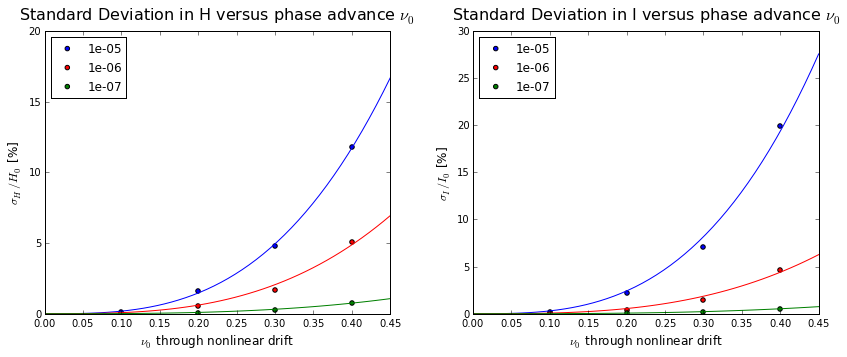

In [625]:
plotHvTune_fullfit(bunchMeans,3)

Fit for H with emittance 1e-05 has RSS 0.036131205941
Fit form is c3*x^3 + c5*x^5
Fit parameters c3:177.985337057 c5:34.3557377938
Fit for I with emittance 1e-05 has RSS 0.138065218683
Fit form is c3*x^3 + c5*x^5
Fit parameters c3:210.341726566 c5:622.511752959
Fit for H with emittance 1e-06 has RSS 0.010074675458
Fit form is c3*x^3 + c5*x^5
Fit parameters c3:44.985204647 c5:210.478999606
Fit for I with emittance 1e-06 has RSS 0.00971894617507
Fit form is c3*x^3 + c5*x^5
Fit parameters c3:32.6390318655 c5:244.354988034
Fit for H with emittance 1e-07 has RSS 0.000350128576243
Fit form is c3*x^3 + c5*x^5
Fit parameters c3:5.50826447617 c5:41.9579173608
Fit for I with emittance 1e-07 has RSS 0.000129686813066
Fit form is c3*x^3 + c5*x^5
Fit parameters c3:4.38266742647 c5:26.1722827459


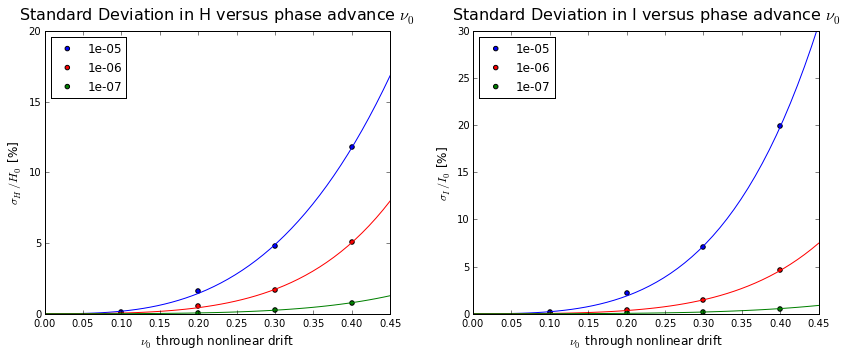

In [630]:
plotHvTune_fullfit(bunchMeans,5)

Fit for H with emittance 1e-06 has RSS 0.0810283103551
Fit parameters c:2.22201496725 c5:-0.105747696446
Fit for I with emittance 1e-06 has RSS 0.0915751779005
Fit parameters c:2.08076724257 c5:-0.104784234574
Fit for H with emittance 1e-07 has RSS 0.0959874230966
Fit parameters c:0.304788206198 c5:-0.106986527317
Fit for I with emittance 1e-07 has RSS 0.0813221374235
Fit parameters c:-0.0326979578508 c5:-0.108197481418
Fit for H with emittance 1e-05 has RSS 0.0976778178656
Fit parameters c:3.21183472706 c5:-0.108620311557
Fit for I with emittance 1e-05 has RSS 0.0791554178571
Fit parameters c:3.63573530303 c5:-0.106392077884


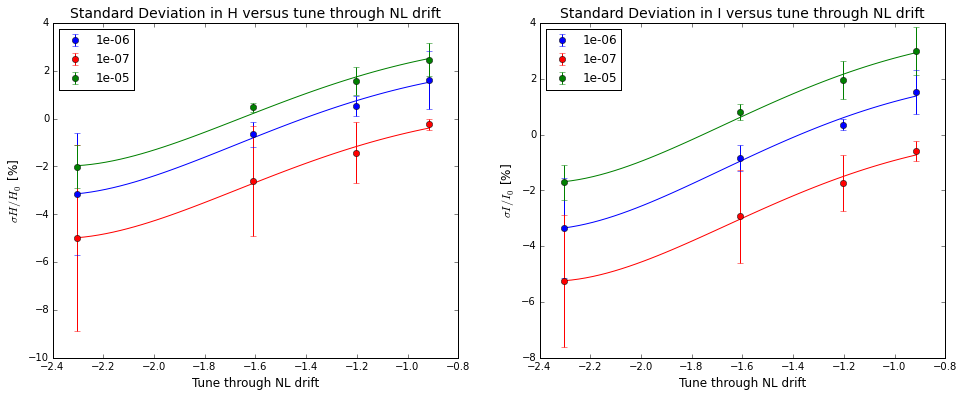

In [315]:
plotHvTune_fullfit(bunchMeans,5)

Fit for H: 1e-06 4.1039470211 0.199088249308
Fit for I: 1e-06 3.94374310383 0.263911729406
Fit for H: 1e-07 2.21109435735 0.171828437757
Fit for I: 1e-07 1.89743381654 0.120413071131
Fit for H: 1e-05 5.15028571801 0.0863642399418
Fit for I: 1e-05 5.53034561304 0.161791664859


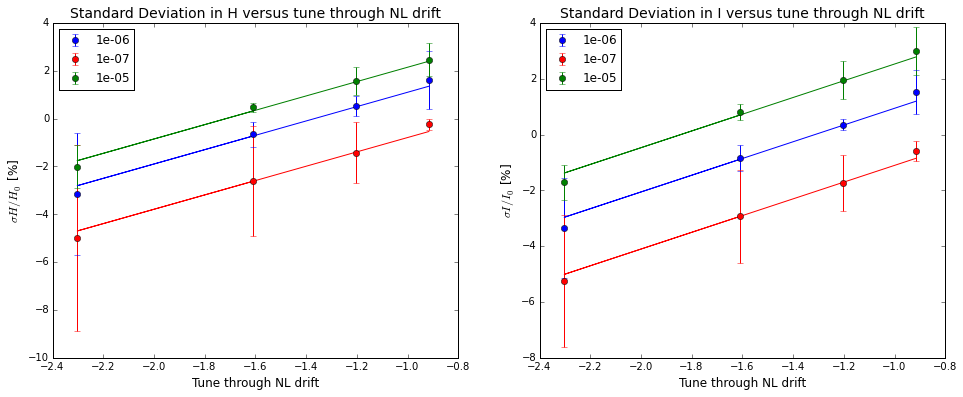

In [260]:
plotHvTune_fullfit(bunchMeans)

1e-06 4.05
1e-07 2.4
1e-05 5.05


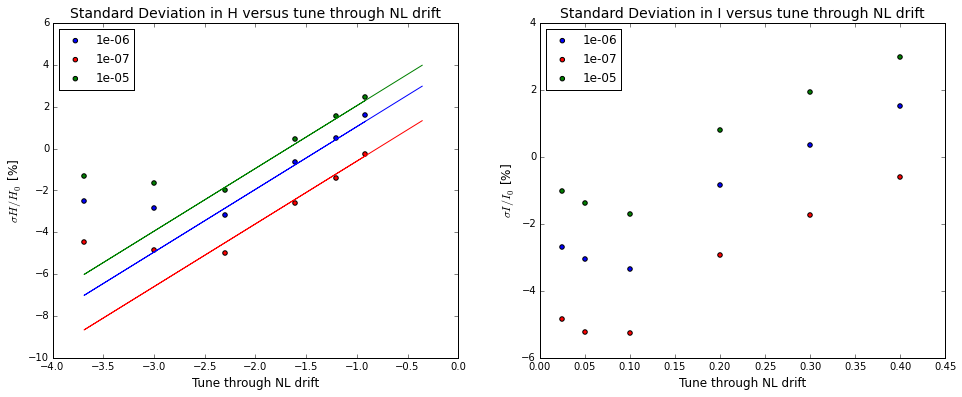

In [119]:
plotHvTune(bunchMeans,log=True,fit=True)

In [41]:
import tables

def plot_bunch(particles_file, opts=None, part=None):
    '''Returns a synergia bunch object constructed from a particles output file.'''
    
    if opts:
        inputfile = os.path.join(opts.output_dir,particles_file)
    else:
        inputfile = particles_file
    f = tables.openFile(inputfile, 'r')
    particles = f.root.particles.read()

    npart = particles.shape[0]
    
    if part:  
        xp = particles[part[0]:part[1],1]
        x = particles[part[0]:part[1],0]
        yp = particles[part[0]:part[1],3]
        y = particles[part[0]:part[1],2]
    else:
        xp = particles[:,1]
        x = particles[:,0]
        yp = particles[:,3]
        y = particles[:,2]        
    
    #one way to use subplots
    #fig, (ax0, ax1, ax2)  = plt.subplots(ncols=3, figsize=(10,6))

    #another way - use gridspec
    #fig = plt.figure(figsize=(9.9,3.3))
    scaleFig=4.5
    fig = plt.figure(figsize=(3*scaleFig,1*scaleFig))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    
    ax0 = plt.subplot(gs[0])
    ax0.scatter(x, y, c='b')
    ax0.set_title('X-Y Coordinate Space',fontsize=14)
    ax0.set_xlabel('x [m]')
    ax0.set_ylabel('y [m]')
    #ax0.set_aspect(aspect=2.0)
    
    ax1 = plt.subplot(gs[1])
    ax1.scatter(x, xp, c='r')
    ax1.set_title('X Trace Space',fontsize=14)
    ax1.set_xlabel('x [m]')
    ax1.set_ylabel('x-prime [rad]')
    #ax1.set_aspect(aspect=2.0)
    
    ax2 = plt.subplot(gs[2])
    ax2.scatter(y, yp, c='g')
    ax2.set_title('Y Trace Space',fontsize=14)
    ax2.set_xlabel('y [m]')
    ax2.set_ylabel('y-prime [rad]')
    #ax2.set_aspect(aspect=2.0)
    
    
    ax2.tick_params(axis='x', pad=5)
    
    # Tweak spacing between subplots to prevent labels from overlapping
    #plt.subplots_adjust(hspace=2)
    
    #set figure title
    #fig.canvas.set_window_title('Bunch Distribution')
    fig.tight_layout()
    
    #tn = f.root.tlen[()] #cumulative distance travelled
    sn = f.root.s_n[()] #s value along lattice for a given turn (e.g. tn mod lattice_length)
    turn_num = f.root.rep[()]
    
    if not sn == 0:
        turn_num +=1
    
    svtitle = "bunch_turn_{}".format(turn_num)
    supertitle = 'Bunch distribution for turn {}'.format(turn_num+1)
    
    if opts:
        svtitle = svtitle +'_' + opts.name + '.pdf'
        supertitle = 'Bunch distribution for NL tune {} at turn {}'.format(opts.new_tune,turn_num)
        #supertitle += ' with NL tune {}'.format(opts.new_tune)
    else:
        svtitle += '.pdf'
    
    plt.suptitle(supertitle, y=1+0.07, fontsize=18)
    plt.show()
    
    fig.savefig(svtitle, bbox_inches='tight')
    print "Saving plot to",svtitle

###Plot of invariants for a single particle over 100 turns

We want to use a quick plot of the turn-by-turn invariants for a single particle. Let's use the 0.3 tune nonlinear element.

In [405]:
opts3 = simulations['0pt3_tune']['opts']
opts3.num = 1
HArray, IArray = elliptic_sp.toy_calc_elliptic_Invariant(opts3)

In [444]:
def make_Hvals(opts, ID=0):

    Hvals = {}
    Ivals = {}

    for index,emit in enumerate(opts.emits):
        ind = int(opts.macro_particles*index + ID)
        Hvals[str(emit)] = HArray[1:,ind]*1.e6
        Ivals[str(emit)] = IArray[1:,ind]*1.e6
        
    return Hvals, Ivals

In [445]:
HV, IV = make_Hvals(opts3)

In [504]:
def makeCombined(Hvals,Ivals):
    count = 0
    combined = {}
    numC =3 
    for key in sorted(Hvals.iterkeys(),reverse=True): #sort from "lowest" emittance value
        combined[str(count)] = {}
        combined[str(count)]['emit'] = key
        combined[str(count)]['vals'] = Hvals[key]
        
        combined[str(count+numC)] = {}
        combined[str(count+numC)]['emit'] = key
        combined[str(count+numC)]['vals'] = Ivals[key]
        count +=1
    return combined

In [505]:
cvals = makeCombined(HV,IV)

In [628]:
from matplotlib import gridspec

def plotSPH(Hvals,Ivals,plotboth=False):
    
    turns = np.arange(100)+1
    numC = 3 #number of plots per row
    if plotboth:
        numR = 2 #number of rows
    else: 
        numR = 1
    numPlot = numC*numR
    dimP = 4 #dimension of each plot (square)
    
    #combine these guys in a better way for automatically plotting
    count = 0
    combined = {}
    for key in sorted(Hvals.iterkeys(),reverse=True): #sort from "lowest" emittance value
        combined[str(count)] = {}
        combined[str(count)]['emit'] = key
        combined[str(count)]['vals'] = Hvals[key]
        
        combined[str(count+numC)] = {}
        combined[str(count+numC)]['emit'] = key
        combined[str(count+numC)]['vals'] = Ivals[key]
        count +=1
    
    fig = plt.figure(figsize=(dimP*numC,dimP*numR))
    gs = gridspec.GridSpec(numR, numC, width_ratios=[1,1,1])
    
    for col in range(numC):

        indH = col #plot H in top row
        ax = plt.subplot(gs[indH])
        #ax.scatter(turns,Hvals['1e-05'])
        ax.scatter(turns,combined[str(indH)]['vals'], s=4, c='k')
        exponent = 6 - int(str(combined[str(indH)]['emit'])[-1]) #convert the exponent to mm-mrad
        #print exponent
        #axtitle = '$H_0$ = ' + str(combined[str(indH)]['emit']) 
        axtitle = "$\epsilon$ = $10^{exp}$ mm-mrad".format(exp = "{"+str(exponent)+"}")
        ax.set_title(axtitle, y = 1.02, fontsize = 16)
        
        ax.set_xlabel("Turn number",fontsize=12)
        ax.set_ylabel("Calculated $H_0$ [mm-mrad]",fontsize=12)
        
        ymin = float(str(combined[str(indH)]['emit']))*0.95*1.e6
        ymax = float(str(combined[str(indH)]['emit']))*1.25*1.e6
        ax.set_ylim([ymin,ymax])
        
        if plotboth:
            indI = col + numC #plot H in top row
            ax = plt.subplot(gs[indI])
            #ax.scatter(turns,Hvals['1e-05'])
            ax.scatter(turns,combined[str(indI)]['vals'])
            axtitle = 'Calculated I for particle with $H_0$ = ' + str(combined[str(indI)]['emit']) 
            ax.set_title(axtitle, y = 1.05)
    
    sv_title = 'SPH_100turns.pdf'
    fig.tight_layout()
    fig.savefig(sv_title,bbox_inches='tight')
        

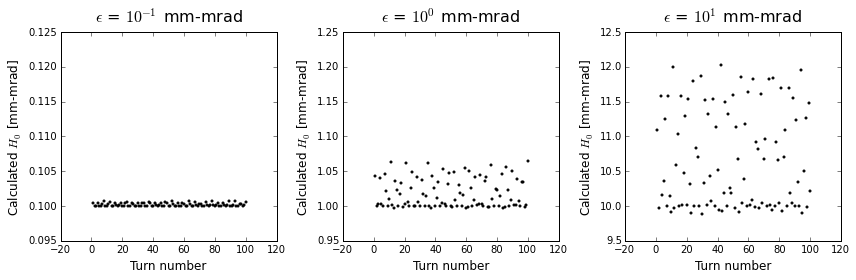

In [629]:
plotSPH(HV,IV)

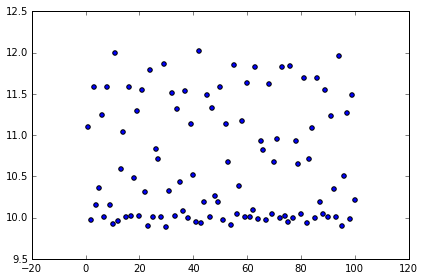

In [427]:
turns = np.arange(100)+1
hvals = HArray[1:,0]*1.e6

plt.scatter(turns,hvals)

####Dump the summary data

In [120]:
listMeans = {}
for key in bunchMeans.keys():
    listMeans[key] = []
    for ar in bunchMeans[key]:
        listMeans[key].append(list(ar))
    #listMeans[key] = list(bunchMeans[key])

In [121]:
#dump analyzed data
import json

#need to reduce everything to lists
listMeans = {}
for key in bunchMeans.keys():
    listMeans[key] = []
    for ar in bunchMeans[key]:
        listMeans[key].append(list(ar))
    #listMeans[key] = list(bunchMeans[key])

outputfile = 'bunch_means.txt'
#outputfileI = 'I_stats.txt'

with open(outputfile, 'w+') as f:
    json.dump(listMeans,f)

#with open(outputfileH, 'w+') as f:
#    json.dump(HS,f)

#with open(outputfileI, 'w+') as f:
#    json.dump(IS,f)

####Test loading the data

In [369]:
#Note that these individual entries are loaded as lists, so I have adjusted my plotting script to cast np.asarray()
#on the lists individually. This should be compatible with all behavior.
outputfileBM = 'bunch_means.txt'
with open(outputfileBM,'r') as f:
    importedBunchMeans = json.load(f)

####Verifying that we are properly matching the beams

Since we are seeing filamentation in the beams (especially for the high tunes), we know that the matching is incorrect. We are seeing immediate filamentation and emittance growth due to this. However, the general shape of the bunch looks reasonable. Moreover, the filamentation growth isn't seen for small tune cases, in which alpha is very small. We deduce that something in the specification of alpha is incorrect. A quick look at Stephen's beam generation code suggests that he didn't include an additional factor of $\sqrt(\beta)$ when transforming back from normalized coordinates to regular coordinates. I have made this adjustment and will take a look at the new beam.

In [5]:
lattice_folder = '/Users/ncook/Synergia_Tests/lattices/6-6_nll_toy_ensemble/'
latticefiles = get_lattice_files(lattice_folder)
simulations = {} #construct a dictionary

In [11]:
from base_diagnostics import workflow
from base_diagnostics import latticework
from base_diagnostics import elliptic_sp
from elliptic import EllipticBeam6D

lattice_folder = '/Users/ncook/Synergia_Tests/lattices/6-6_nll_toy_ensemble/'
latticefiles = get_lattice_files(lattice_folder)
simulations = {} #construct a dictionary

latticefile = latticefiles[-1]
lattice = synergia.lattice.MadX_reader().get_lattice("base", os.path.join(lattice_folder,latticefile))

#annoying stuff to extract name and tune
name = Find(r'\dpt\d+_',latticefile)[:-1]
decimals = Find(r'pt\d+',name)[2::]
l = len(decimals)
tune = int(decimals)/(10.**l)

for elem in lattice.get_elements():
    if elem.get_type() == 'nllens':
        elem.set_string_attribute("extractor_type", "chef_propagate")

nsteps_per_element = 10
nsteps = len(lattice.get_elements())*nsteps_per_element
order = 1

name += '_tune'
outputdir = name
opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.macro_particles = 1000
opts.emits = [1.0e-5, 1.0e-7] #only constructing bunches of 2 different sizes here
opts.lattice = lattice
workflow.make_path(outputdir)
opts.relpath = opts.output_dir

stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()


#construct the R-matrix
opts.new_tune = tune
opts.lnll = lattice.get_length()
opts.nseg = 40
opts.t = 0.4
opts.c = 0.01
vals = get_base_nll(opts.nseg, opts.lnll, opts.new_tune, opts.t, opts.c)

opts.f0 = vals[0]
opts.betae = vals[1]
opts.alphae = vals[2]
opts.beta0 = vals[3]

toy_R = latticework.make_R(opts.f0)

#construct the operator using our toy R matrix
turn_action = turn_actions(toy_R)

#construct a bunch and populate with 3 particles of varying emittance
particles = EllipticBeam6D.toyEllipticalBeam6D(opts)
                 
for index in range(len(opts.emits)):
    bunch = particles[index]
    initialH,initialI = elliptic_sp.calc_bunch_H(bunch,opts)
    bunch_mean = np.mean(initialH)
    bunch_std = np.std(initialH)
    bunch_var = (bunch_std/bunch_mean)*100
    print "Constructed bunch with {} macroparticles, having mean H: {} and std: {}%".format(opts.macro_particles, bunch_mean,bunch_var)

opts.num_total_particles = opts.macro_particles*len(opts.emits)
opts.tracked_particles = opts.num_total_particles
    
#load the particles into a synergia bunch
particles_file = 'myBunch' + str(name) + '.txt'
comm = synergia.utils.Commxx(True)
bucket_length = 0.05 #potential workaround
ref = lattice.get_reference_particle()
myBunch = synergia.bunch.Bunch(ref,opts.num_total_particles, opts.real_particles, comm,bucket_length)
local_particles = myBunch.get_local_particles()
local_particles[:,:] = particles.reshape((opts.num_total_particles,7))[::]

#construct a bunch simulator and add diagnostics
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_step(diagnostics)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag)


#populate the dictionary storing relevant simulation parameters, objects, and pointers to data
keyname = name + 'alpha'
simulations[keyname] = {}

current = simulations[keyname]
current['lattice'] = lattice
current['tune'] = tune
current['outputdir'] = outputdir
current['lattice_simulator'] = lattice_simulator
current['stepper'] = stepper
current['opts'] = opts
current['R_matrix'] = toy_R
current['vals'] = vals
current['turn_action'] = turn_action
current['bunch'] = myBunch
current['bunch_simulator'] = bunch_simulator


print "Performing simulation for lattice " + str(name) + "."

#now perform the simulation
opts.turns = 100
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator, turn_action,
                 opts.turns, opts.maxturns,opts.verbosity)

#clean up files
workflow.cleanup(opts.output_dir)

Constructed bunch with 1000 macroparticles, having mean H: 1.08272682896e-05 and std: 15.5978513485%
Constructed bunch with 1000 macroparticles, having mean H: 1.00741759659e-07 and std: 1.4116776872%
Performing simulation for lattice 0pt4_tune.


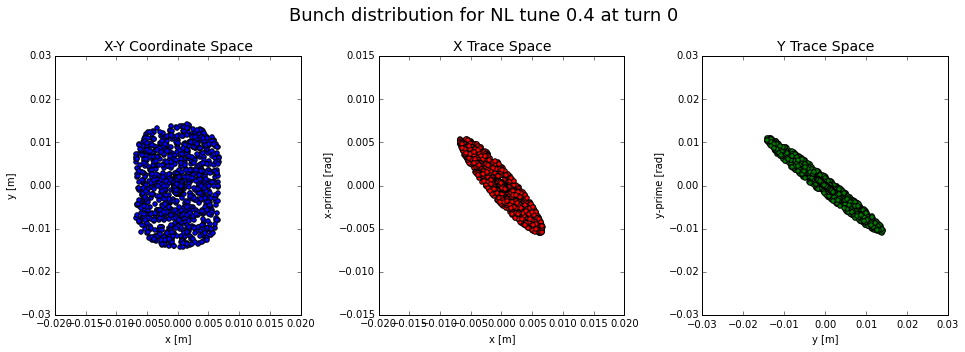

Saving plot to bunch_turn_0_0pt4_tune.pdf


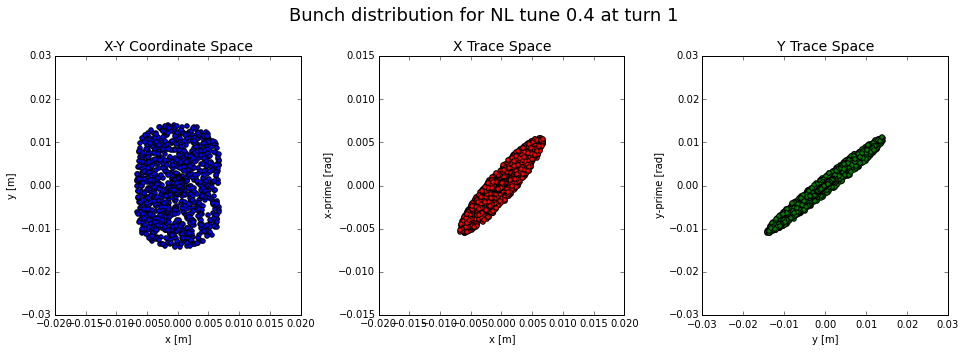

Saving plot to bunch_turn_1_0pt4_tune.pdf


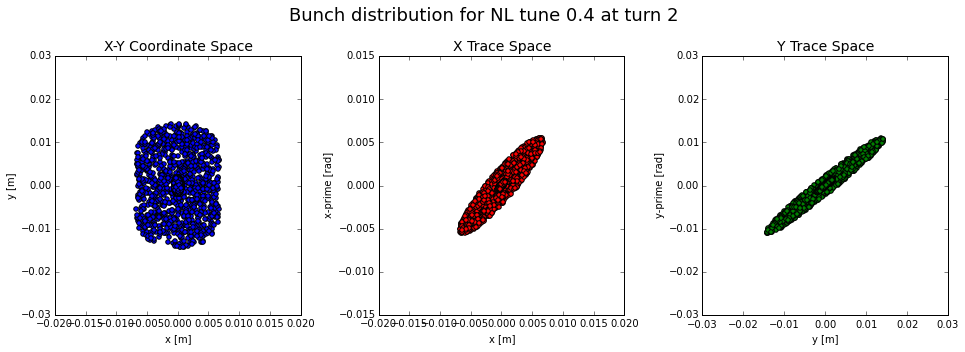

Saving plot to bunch_turn_2_0pt4_tune.pdf


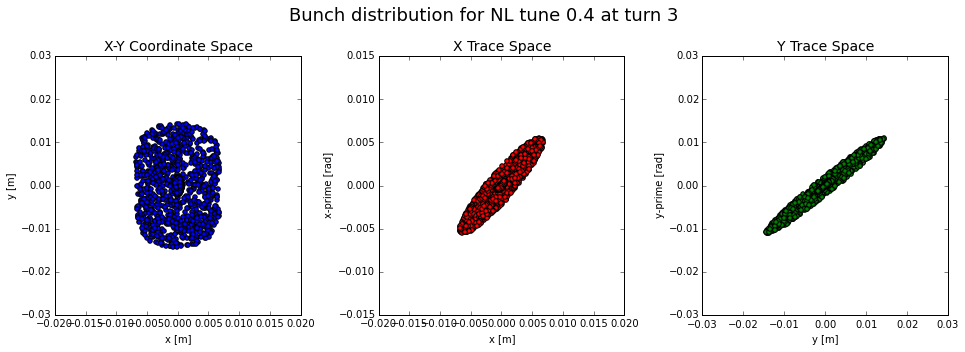

Saving plot to bunch_turn_3_0pt4_tune.pdf


In [24]:
from matplotlib import gridspec
plot_bunch('particles_0000.h5',simulations['0pt4_tunealpha']['opts'])
plot_bunch('particles_0001.h5',simulations['0pt4_tunealpha']['opts'])
plot_bunch('particles_0002.h5',simulations['0pt4_tunealpha']['opts'])
plot_bunch('particles_0003.h5',simulations['0pt4_tunealpha']['opts'])

###Extra Code snippets for testing

In [7]:
lattice_folder = '/Users/ncook/Synergia_Tests/lattices/6-6_nll_toy_ensemble/'
latticefiles = get_lattice_files(lattice_folder)
simulations = {} #construct a dictionary

In [170]:
for index in range(len(opts.emits)):
    bunch = particles[index]
    initialH,initialI = elliptic_sp.calc_bunch_H(bunch,opts)
    bunch_mean = np.mean(initialH)
    bunch_std = np.std(initialH)
    bunch_var = (bunch_std/bunch_mean)*100
    print "Constructed bunch with {} macroparticles, having mean H: {} and std: {}%".format(opts.macro_particles, bunch_mean,bunch_var)

Constructed bunch with 1000 macroparticles, having mean H: 9.65063650842e-06 and std: 9.93362865702%
Constructed bunch with 1000 macroparticles, having mean H: 9.97788421108e-08 and std: 0.427444095416%


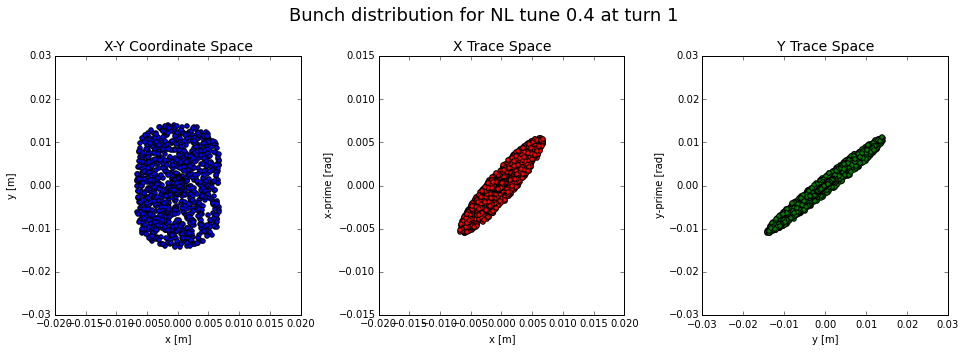

Saving plot to bunch_turn_1_0pt4_tune.pdf


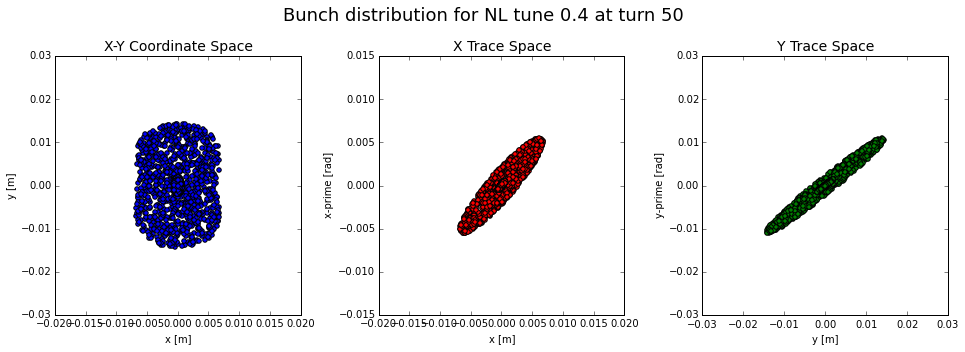

Saving plot to bunch_turn_50_0pt4_tune.pdf


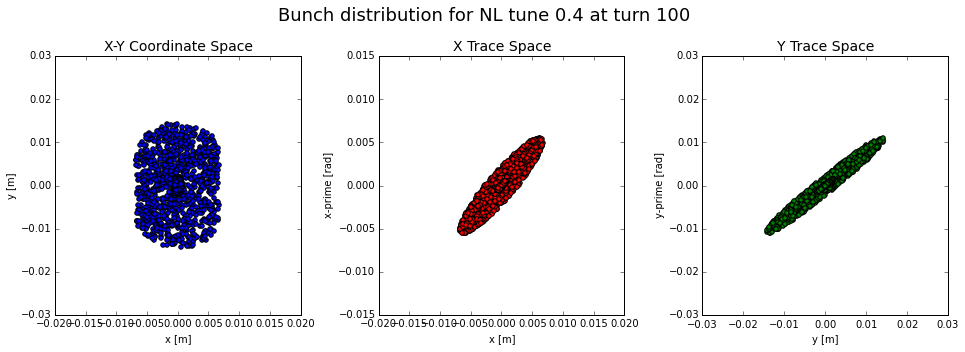

Saving plot to bunch_turn_100_0pt4_tune.pdf


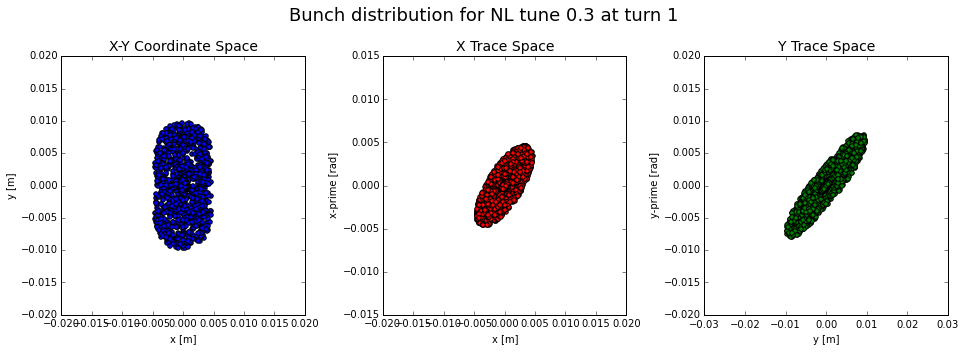

Saving plot to bunch_turn_1_0pt3_tune.pdf


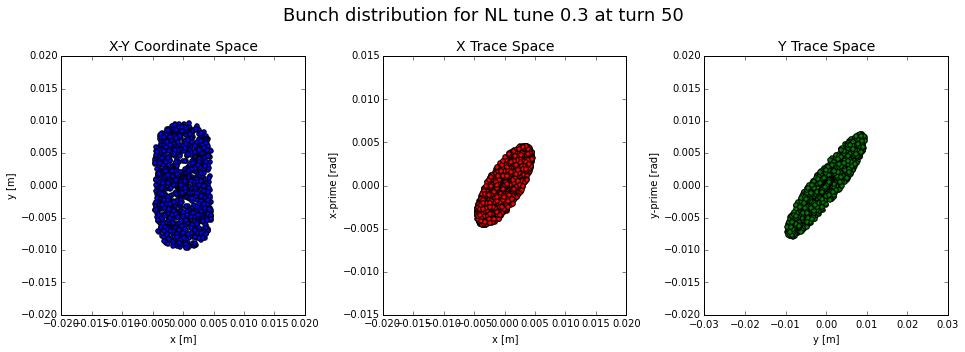

Saving plot to bunch_turn_50_0pt3_tune.pdf


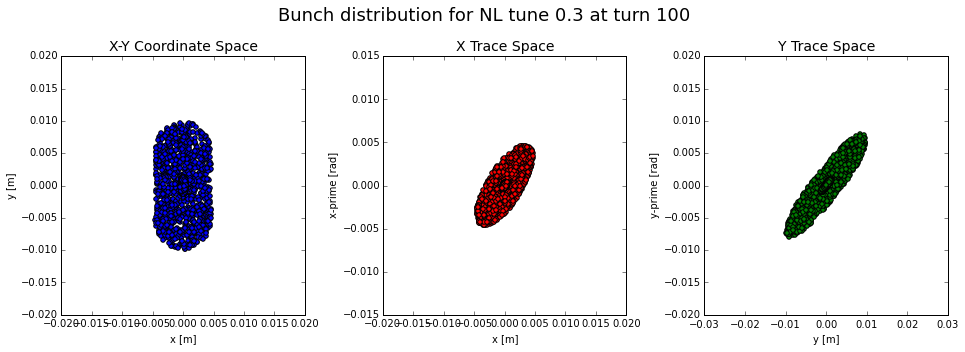

Saving plot to bunch_turn_100_0pt3_tune.pdf


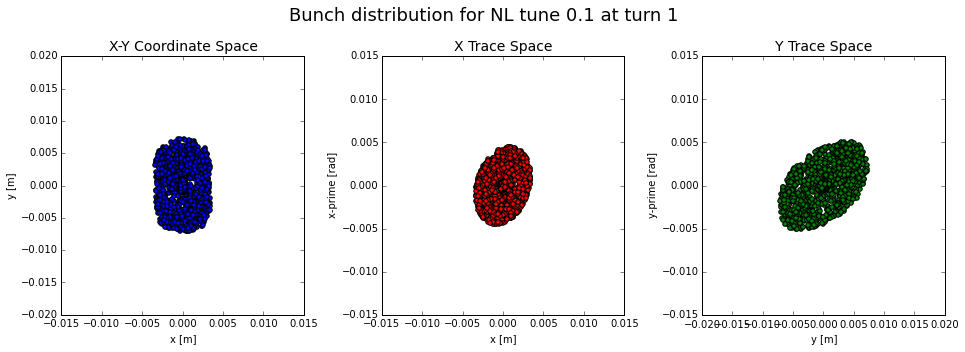

Saving plot to bunch_turn_1_0pt1_tune.pdf


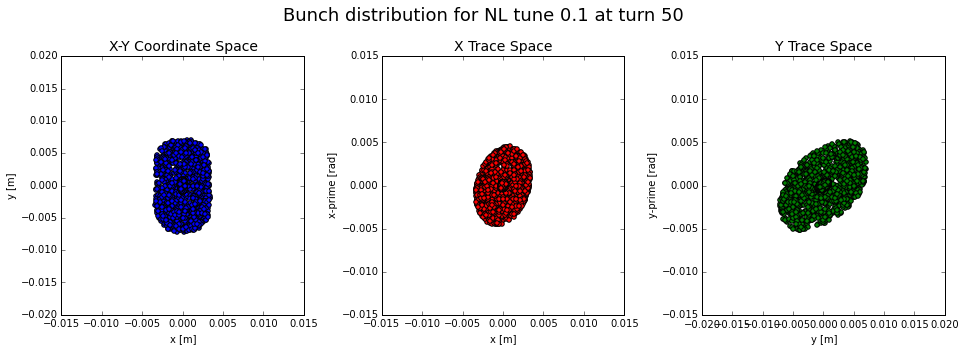

Saving plot to bunch_turn_50_0pt1_tune.pdf


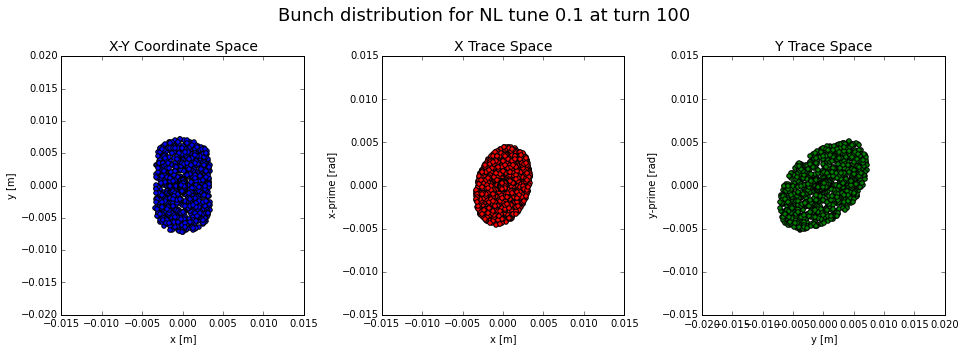

Saving plot to bunch_turn_100_0pt1_tune.pdf


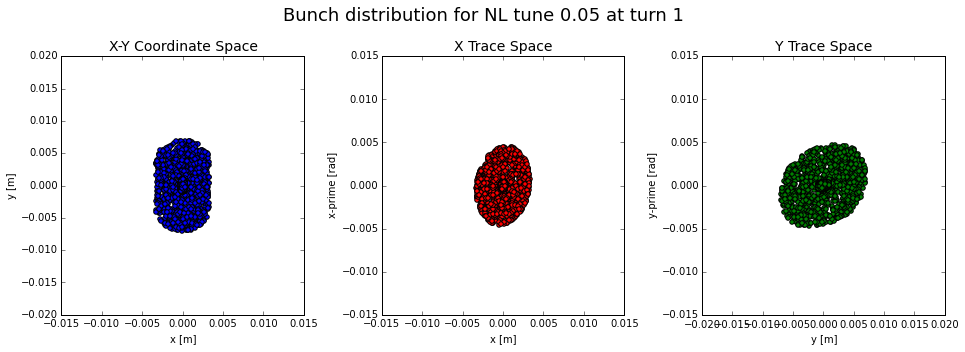

Saving plot to bunch_turn_1_0pt05_tune.pdf


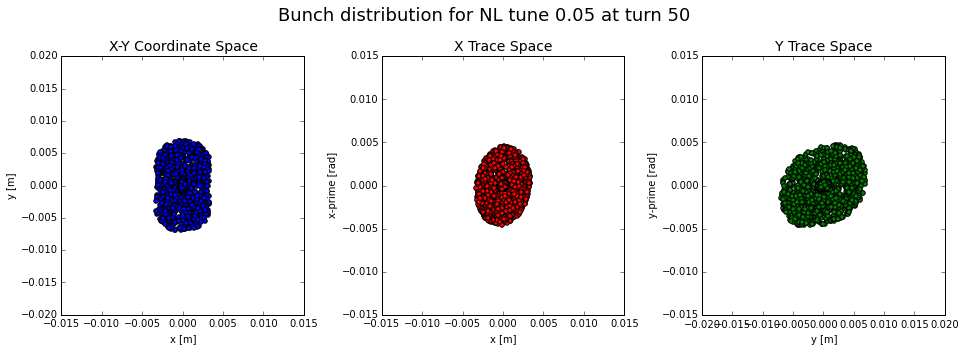

Saving plot to bunch_turn_50_0pt05_tune.pdf


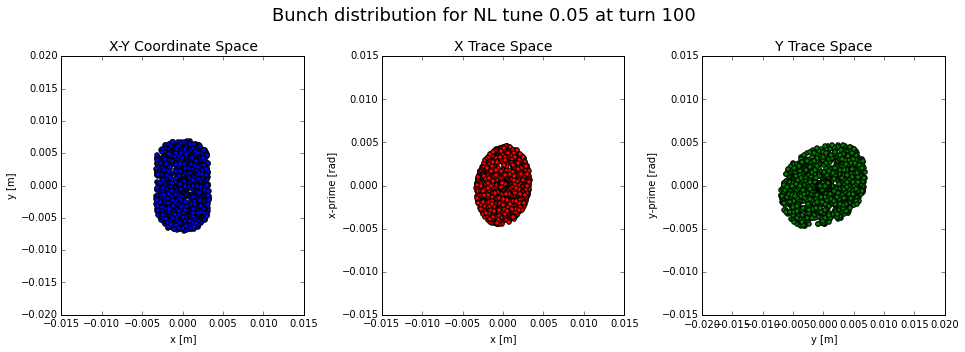

Saving plot to bunch_turn_100_0pt05_tune.pdf


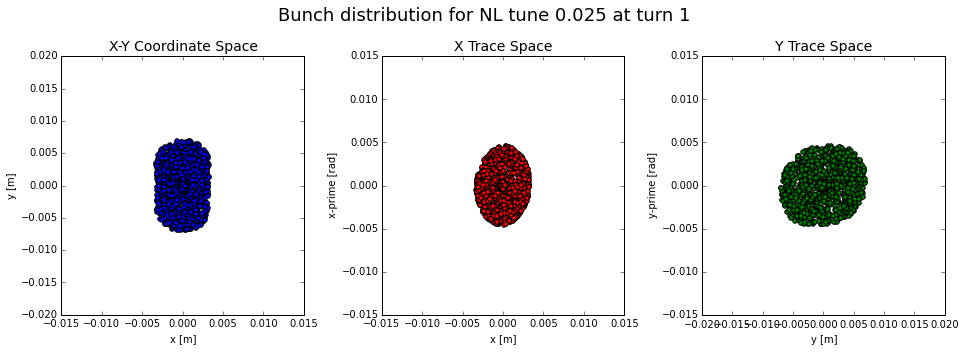

Saving plot to bunch_turn_1_0pt025_tune.pdf


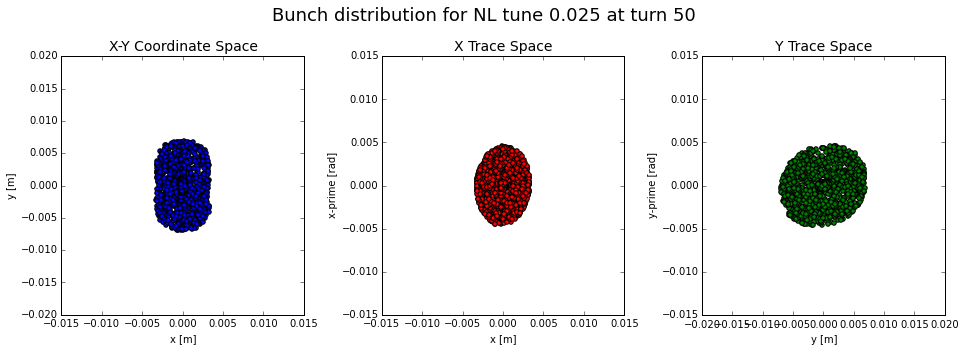

Saving plot to bunch_turn_50_0pt025_tune.pdf


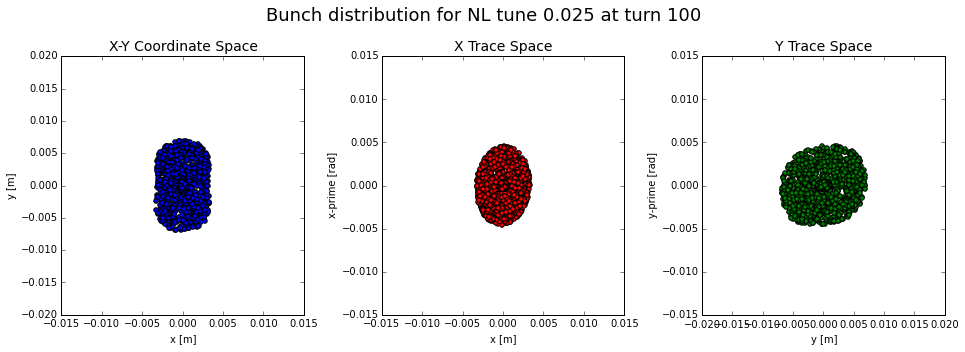

Saving plot to bunch_turn_100_0pt025_tune.pdf


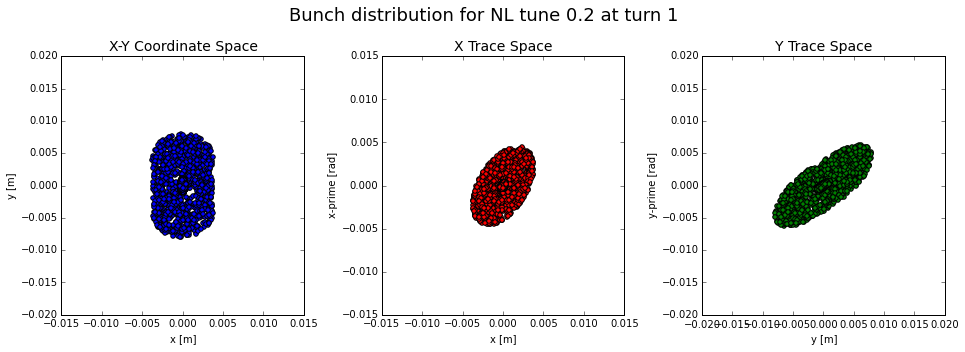

Saving plot to bunch_turn_1_0pt2_tune.pdf


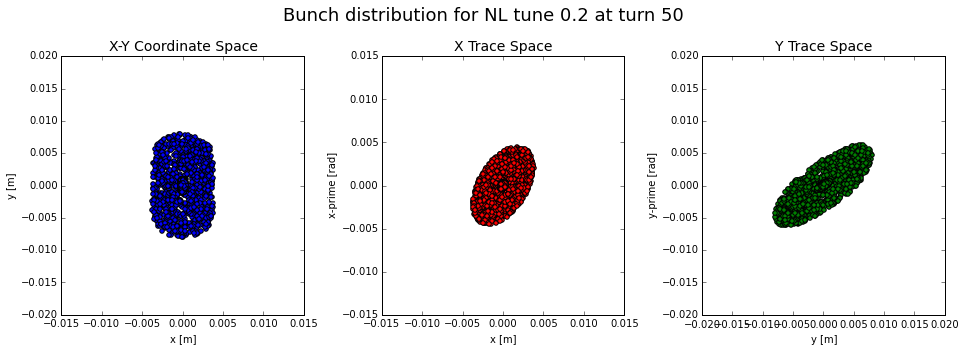

Saving plot to bunch_turn_50_0pt2_tune.pdf


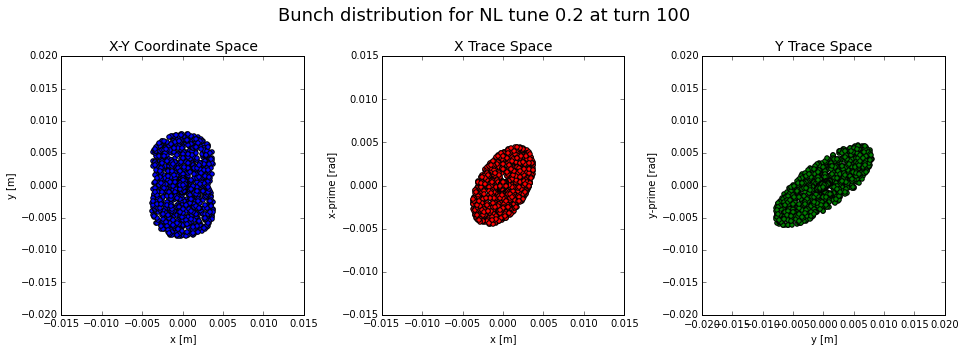

Saving plot to bunch_turn_100_0pt2_tune.pdf


In [49]:
pfiles = ['particles_0001.h5','particles_0050.h5','particles_0100.h5']

for key in simulations.keys():
    current_opts = simulations[key]['opts']
    
    for pfile in pfiles:
        plot_bunch(pfile,current_opts)